# Loading Data 

## Importing libraries and data files

In [1]:
import os
import tensorflow as tf
import datetime
import sys
import utility_functions 
from os import path
import numpy as np
import pandas as pd
import importlib
import omnidata
from utility_functions import datafrompd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

omnifile = os.getcwd() + '/omni2_2010-2015.dat'
pval = 0.3  # Proportion of the data used for the testing
useomni = True  # Read data from raw OMNIweb files
outcols = ['Dst']
incols = ['V_plasma', 'Bz_GSM', 'av_|B|', 'Dst']
t_dt = 1  # History time interval (hours). Basically how many points you "skip". 1 = no skipping
t_nt = 3  # Number of samples in the past (hours). e.g., 5 means you will be using 5 hours of data before the event
t_fcast = 3  # Forecasting time (hours)

odata, mask = omnidata.read(omnifile)
X, Y, m = datafrompd(t_dt, t_nt, t_fcast, odata, mask, incols, outcols)


2023-09-02 17:59:11.786854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Split dataset in train and test

As in the other examples, we need to seperate the datasets

In [2]:
# Split the data

m_testn = int(pval * m)
m_train = m - m_testn

x_train = X[:m_train, :]
y_train = Y[:m_train, :]
x_test = X[-m_testn:, :]
y_test = Y[-m_testn:, :]


# Add a min_max scaler which is fited in training data
standar_scaler_model= preprocessing.StandardScaler()
standar_scaler_model.fit(x_train)  

x_train = standar_scaler_model.transform(x_train) # Transform to normalized data 
x_test = standar_scaler_model.transform(x_test) # Transform to normalized data 

## Example of Model Setup

Let's setup a model below

In [3]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from tensorflow.keras.utils import to_categorical

nin = x_train.shape[1]
optimizer_choice_1 = 'Adam'

model_used = simple_model(nin,optimizer_choice_1)

2023-09-02 18:00:33.929667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-02 18:00:33.930032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Example of Training proccedure


Let's now train our model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='mean_squared_error' , patience=30 , verbose=1,
                                   mode ='auto', restore_best_weights= True)

history = model_used.fit(x_train, y_train, epochs=10, 
                         verbose=1, 
                         callbacks=[early_stop])

Epoch 1/10
1151/1151 [==============================] - 10s 9ms/step - loss: 113.4883 - mean_squared_error: 113.4883 - rmse: 7.8334 - r_square: 0.4956
Epoch 2/10
1151/1151 [==============================] - 10s 9ms/step - loss: 113.1112 - mean_squared_error: 113.1112 - rmse: 7.8224 - r_square: 0.5062
Epoch 3/10
1151/1151 [==============================] - 10s 9ms/step - loss: 112.9471 - mean_squared_error: 112.9471 - rmse: 7.8223 - r_square: 0.4966
Epoch 4/10
1151/1151 [==============================] - 10s 8ms/step - loss: 113.0908 - mean_squared_error: 113.0908 - rmse: 7.8182 - r_square: 0.5025
Epoch 5/10
1151/1151 [==============================] - 10s 9ms/step - loss: 112.7377 - mean_squared_error: 112.7377 - rmse: 7.8096 - r_square: 0.5028
Epoch 6/10
1151/1151 [==============================] - 10s 8ms/step - loss: 112.7706 - mean_squared_error: 112.7706 - rmse: 7.8112 - r_square: 0.5013
Epoch 7/10
1151/1151 [==============================] - 10s 8ms/step - loss: 112.5556 - mean_s

# Visualziating results (simple metrics)

Let's see the results

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

predictions = model_used.predict(x_test)
    
def regression_metrics(y_true, y_predictions):

    explained_variance=metrics.explained_variance_score(y_true, y_predictions)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_predictions) 
    mse=metrics.mean_squared_error(y_true, y_predictions) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_predictions)
    r2=metrics.r2_score(y_true, y_predictions)

    print('explained_variance: ', round(explained_variance,3))    
    print('median absolute error: ', round(median_absolute_error,3))    
    print('r2: ', round(r2,3))
    print('MAE: ', round(mean_absolute_error,3))
    print('MSE: ', round(mse,3))
    print('RMSE: ', round(np.sqrt(mse),3))
    
regression_metrics(y_test,predictions)

493/493 [==============================] - 1s 2ms/step
explained_variance:  0.577
median absolute error:  7.451
r2:  0.556
MAE:  9.546
MSE:  163.579
RMSE:  12.79


 52/493 [==>...........................] - ETA: 0s

2023-09-02 18:05:06.777774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


493/493 [==============================] - 1s 2ms/step


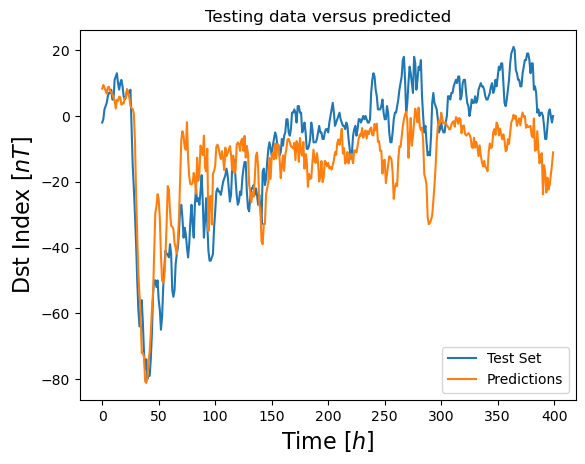

In [6]:
import matplotlib.pyplot as plt

prediction = model_used.predict(x_test)
Y_test=np.concatenate(x_test)

m0 = int(m_testn/4)
m1 = min(m0+400,m_testn)

plt.title('Testing data versus predicted')
plt.plot(y_test[m0:m1], label='Test Set')
plt.plot(prediction[m0:m1], label='Predictions')
plt.legend()
plt.xlabel('Time $[h]$',fontsize=16)
plt.ylabel('Dst Index $[nT]$',fontsize=16)
plt.show()